In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import re

plt.rcParams["font.size"] = 24

In [8]:
def get_data_from_file(file_path, spmm_method, gemm_method, get_gemm_flag):
    df = pd.read_csv(file_path)
    if get_gemm_flag:
        df = df[['m', 'k', 'n', 'spmm_time', 'gemm_time']]
        df = df.rename(columns={'spmm_time': spmm_method, 'gemm_time': gemm_method})
    else:
        df = df[['m', 'k', 'n', 'spmm_time']]
        df = df.rename(columns={'spmm_time': spmm_method})
    return df

def get_data_from_file_ssmm(file_path):
    with open(file_path, 'r') as file:
        file_data = file.read()
    pattern = r"Running with m=(\d+), n=(\d+), k=(\d+).*?One iter for SSMM kernel is :([\d.]+) ms"
    matches = re.findall(pattern, file_data, re.DOTALL)
    results = [{"m": int(m), "n": int(n), "k": int(k), "ssmm": float(time)} for m, n, k, time in matches]
    results = pd.DataFrame(results)
    return results

In [9]:
directory = '../results/kernel/'
ssmm_files = [f for f in os.listdir(directory) if f.startswith('SSMM')]
ssmm_devices = [f.split('_')[1].replace('.txt', '') for f in ssmm_files]
ssmm_file_cata_df = pd.DataFrame({
    'file': ssmm_files,
    'devices': ssmm_devices
})

other_files = [f for f in os.listdir(directory) if f.endswith('.txt') and not f.startswith('SSMM')]
other_devices = [f.split('_')[3].replace('.txt', '') for f in other_files]
other_gemm_method = [os.path.splitext(f.split('_')[2])[0] for f in other_files]
other_ssmm_method = [os.path.splitext(f.split('_')[0])[0] for f in other_files]
other_file_cata_df = pd.DataFrame({
    'file': other_files,
    'devices': other_devices,
    'gemm_method': other_gemm_method,
    'ssmm_method': other_ssmm_method,
})

In [10]:
unique_devices = ssmm_file_cata_df['devices'].unique()
data_dict = {}
for d in unique_devices:
    ssmm_files = ssmm_file_cata_df[ssmm_file_cata_df['devices'] == d]['file']
    other_files = other_file_cata_df[other_file_cata_df['devices'] == d]['file']
    for ssmm_file in ssmm_files:
        data = get_data_from_file_ssmm(directory + ssmm_file)
    get_gemm_flag = True
    for other_file in other_files:
        if get_gemm_flag:
            other_data = get_data_from_file(directory + other_file, other_file_cata_df[other_file_cata_df['file'] == other_file]['ssmm_method'].values[0], other_file_cata_df[other_file_cata_df['file'] == other_file]['gemm_method'].values[0], get_gemm_flag)
            data = pd.merge(data, other_data, on=['m', 'k', 'n'])
            get_gemm_flag = False
        else:
            other_data = get_data_from_file(directory + other_file, other_file_cata_df[other_file_cata_df['file'] == other_file]['ssmm_method'].values[0], other_file_cata_df[other_file_cata_df['file'] == other_file]['gemm_method'].values[0], get_gemm_flag)
            data = pd.merge(data, other_data, on=['m', 'k', 'n'])

    data['shape'] = data.iloc[:, :3].astype(str).apply('_'.join, axis=1)
    data['num_blocks'] = data['m'] // 128 * data['n'] // 64
    columns_to_norm = ['ssmm', 'Venom', 'cuBlas', 'Sputnik', 'cuSparseLt', 'cuSparseLtsearched']
    
    # Calculate the TFLOPS of matrix multiplication
    for column in columns_to_norm:
        data[column] = data['m'] * data['n'] * (2 * data['k'] - 1) / ((data[column] * 1e-3)) * 1e-12

    data_dict[d] = data

In [11]:
column_names_with_device = ['Sputnik', 'cuBlas', 'cuSparseLtsearched', 'Venom', 'ssmm', 'device']
column_names_without_device = ['Sputnik', 'cuBlas', 'cuSparseLtsearched', 'Venom', 'ssmm']
df = None
for device, data in data_dict.items():
    data = data[data['num_blocks'] > 128]
    mean_values = data[column_names_without_device].mean().values
    new_row = list(mean_values) + [device]
    if df is None:
        df = pd.DataFrame([new_row], columns=column_names_with_device)
    else:
        temp_df = pd.DataFrame([new_row], columns=column_names_with_device)
        df = df._append(temp_df, ignore_index=True)

name_mapping = {'Sputnik': 'Sputnik', 'cuBlas': 'cuBLAS', 'cuSparseLtsearched': 'cuSPARSELt', 'Venom': 'VENOM', 'ssmm': 'Samoyeds'}
df = df.rename(columns=name_mapping)

device_order = ['NVIDIA.GeForce.RTX.3090', 'NVIDIA.GeForce.RTX.4070.SUPER', 'NVIDIA.GeForce.RTX.4090', 'NVIDIA.A100-PCIE-40GB']
df['device'] = pd.Categorical(df['device'], categories=device_order, ordered=True)
df = df.sort_values('device')

df_normalized = df.copy()

df['device'] = df['device'].replace('NVIDIA.GeForce.RTX.4070.SUPER', '4070S')
df['device'] = df['device'].replace('NVIDIA.GeForce.RTX.3090', '3090')
df['device'] = df['device'].replace('NVIDIA.GeForce.RTX.4090', '4090')
df['device'] = df['device'].replace('NVIDIA.A100-PCIE-40GB', 'A100')

df.set_index('device', inplace=True)
df = df / 100.0

/tmp/ipykernel_664966/1100442045.py:23: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['device'] = df['device'].replace('NVIDIA.GeForce.RTX.4070.SUPER', '4070S')
/tmp/ipykernel_664966/1100442045.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['device'] = df['device'].replace('NVIDIA.GeForce.RTX.3090', '3090')
/tmp/ipykernel_664966/1100442045.py:25: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the c

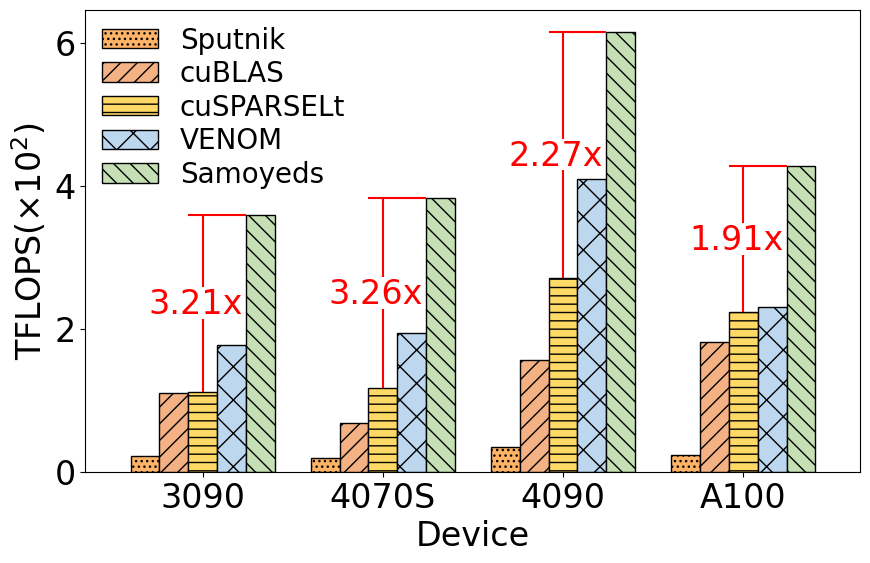

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#FFB366', '#F4B183', '#FFD966', '#BDD7EE', '#C5E0B4']
df.plot(kind='bar', ax=ax, width=0.8, color=colors, edgecolor='black', rot=0, linewidth=1)

# 给每个颜色的柱子加上不同的填充hatch
hatches = ['...', '//', '--', 'x', '\\\\']  # 定义填充样式
color_to_hatch = dict(zip(colors, hatches))
for i, bar in enumerate(ax.patches):
    hex_color = mcolors.to_hex(bar.get_facecolor()).upper()
    bar.set_hatch(color_to_hatch[hex_color])

cfg_counter = 0
for idx, row in df.iterrows():
    patch_idx = cfg_counter + 2 * df.shape[0]
    cusaprselt_patch = ax.patches[patch_idx]
    samoyeds_patch = ax.patches[patch_idx + 2 * df.shape[0]]
    improvement = row['Samoyeds'] / row['cuSPARSELt']
    ax.hlines(samoyeds_patch.get_height(), xmin=cusaprselt_patch.get_x(), xmax=cusaprselt_patch.get_x() + 2 * cusaprselt_patch.get_width(), colors='red')

    text_space = 0.22
    text_yoffset = -0.015
    text_xoffset = 0.04
    ax.vlines(cusaprselt_patch.get_x() + cusaprselt_patch.get_width() / 2, ymin=cusaprselt_patch.get_height(), ymax=(cusaprselt_patch.get_height() + samoyeds_patch.get_height())/2 - text_space, colors='red')
    ax.vlines(cusaprselt_patch.get_x() + cusaprselt_patch.get_width() / 2,  ymin=(cusaprselt_patch.get_height() + samoyeds_patch.get_height())/2 + text_space, ymax=samoyeds_patch.get_height(), colors='red')
    ax.text(cusaprselt_patch.get_x() + text_xoffset, (cusaprselt_patch.get_height() + samoyeds_patch.get_height())/2 + text_yoffset, f'{improvement:.2f}x', ha='center', va='center', color='red')

    cfg_counter += 1

# Set labels and title with enhanced formatting
ax.set_xlabel("Device")
ax.set_ylabel(r'TFLOPS($\times 10^2$)')

legend = ax.legend(loc='upper left', ncol=1, frameon=False, borderpad=0.1, labelspacing=0.2, fontsize=20)

# Show the plot
plt.show()